# SCALING AND NORMALIZATION : STANDARDIZATION (Z-SCORE NORMALIZATION)

<br>

## Introduction

<br>
<b>Standardization</b> (or Z-Score Normalization) <b>is a linear technique which rescale the features so that they have the properties of a standard normal distribution</b> (zero mean and unit variance) :

<br>
$
    \quad
    \boldsymbol{X_i}^{\star}  = \dfrac {\boldsymbol{X_i} - \mu_X} {\sigma_X}
$

<br>
<b>Standardizing the features</b> so that they are centered around 0 with a standard deviation of 1 is not only important if we are comparing measurements that have different units, but it <b>is also a general requirement for many machine learning algorithms</b>. Some (only a few) examples of algorithms where feature scaling matters are:

<br>
<ul style="list-style-type:square">
    <li>
        k-nearest-neighbors with an Euclidean distance measure (if want all features to contribute equally)
    </li>
    <br>
    <li>
        k-means (see k-nearest neighbors)
    </li>
    <br>
    <li>
        logistic regression, SVM, perceptrons, neural networks etc. (if we are using gradient descent/ascent-based optimization,
        otherwise some weights will update much faster than others)
    </li>
    <br>
    <li>
        linear discriminant analysis, principal component analysis, and kernel principal component analysis, since we want to
        find directions of maximizing the variance (under the constraints that those directions/eigenvectors/principal
        components are orthogonal); we want to have features on the same scale since we would emphasize variables on "larger
        measurement scales"
    </li>
</ul>

<br>
The only family of algorithms that we could think of being scale-invariant are tree-based methods. 

## Normalization or Standardization

<br>
There is no obvious answer to this question, it really <b>depends on the application</b>.

<br>
For example, in clustering analyses, standardization may be especially crucial in order to compare similarities between features based on certain distance measures. Another prominent example is PCA, where we usually prefer standardization over normalization, since we are interested in the components that maximize the variance (depending on the question and if the PCA computes the components via the correlation matrix instead of the covariance matrix).

<br>
However, this doesn’t mean that normalization is not useful; a popular application is image processing, where pixel intensities have to be normalized to fit within a certain range (i.e. 0 to 255 for the RGB color range). Also, typical neural network algorithm require data on a [0,1] scale.

<br>
<b>When in doubt</b> between normalization and standardization, please <b>bear in mind that some algorithms assume the features to be centered at zero</b>.

In [1]:
# SETUP : importing

import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
import math

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

import utilcompute as uc
import utilplot as up
import preprocessing as pre

from scipy import stats


C:\Users\danis_p50\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# SETUP : reading in the datasets

data = np.column_stack( (load_boston().data, load_boston().target) )
df = pd.DataFrame(data)
df.columns = [
    'CRIM',    # per capita crime rate by town
    'ZN',      # proportion of residential land zoned for lots over 25,000 sq.ft.
    'INDUS',   # proportion of non-retail business acres per town
    'CHAS',    # Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
    'NOX',     # nitric oxides concentration (parts per 10 million)
    'RM',      # average number of rooms per dwelling
    'AGE',     # proportion of owner-occupied units built prior to 1940
    'DIS',     # weighted distances to five Boston employment centres
    'RAD',     # index of accessibility to radial highways
    'TAX',     # full-value property-tax rate per $10,000
    'PTRATIO', # pupil-teacher ratio by town
    'B',       # 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
    'LSTAT',   # % lower status of the population
    'MEDV'     # median value of owner-occupied homes in $1000's
]


In [3]:
#df.describe()

In [4]:
# SHUFFLING 

seed = 10
np.random.seed(seed)

df = df.reindex(np.random.permutation(df.index))


In [5]:
# FEATURES SELECTION 

target = 'MEDV'
features = [c for c in df.columns if (c != target)]


In [6]:
# DATA PRE-PROCESSING : standardization

selected_features = ['RM', 'B', 'PTRATIO']
excluded_features = [f for f in features if (f not in selected_features)]

df_cnt = pre.center(df = df, included = selected_features, excluded = uc.concatenate(excluded_features,[target]))


In [7]:
# FEATURE SELECTION

selected_features = ['RM', 'B', 'PTRATIO']
excluded_features = [f for f in features if (f not in selected_features)]

df_std = pre.standardize(df = df, included = selected_features, excluded = uc.concatenate(excluded_features,target))


In [8]:
linear_list = [
    { 'df' : df,     'linear_model_name' : 'LinearRegression', 
     'linear_model_args' : {'fit_intercept' : True}, 'note' : 'original' },
    { 'df' : df_std, 'linear_model_name' : 'LinearRegression', 
     'linear_model_args' : {'fit_intercept' : True}, 'note' : 'standardized' },   
]

results = pd.DataFrame()

for l in linear_list:
    results_temp = uc.compute_kfold_stats(
        df = l['df'], 
        features = features, 
        target = [target], 
        linear_model_name = l['linear_model_name'], 
        linear_model_args = l['linear_model_args'],
        note = l['note']
    )
    results = results.append(results_temp).reset_index(drop = True)
    

## Impact on the transformed features

<br>

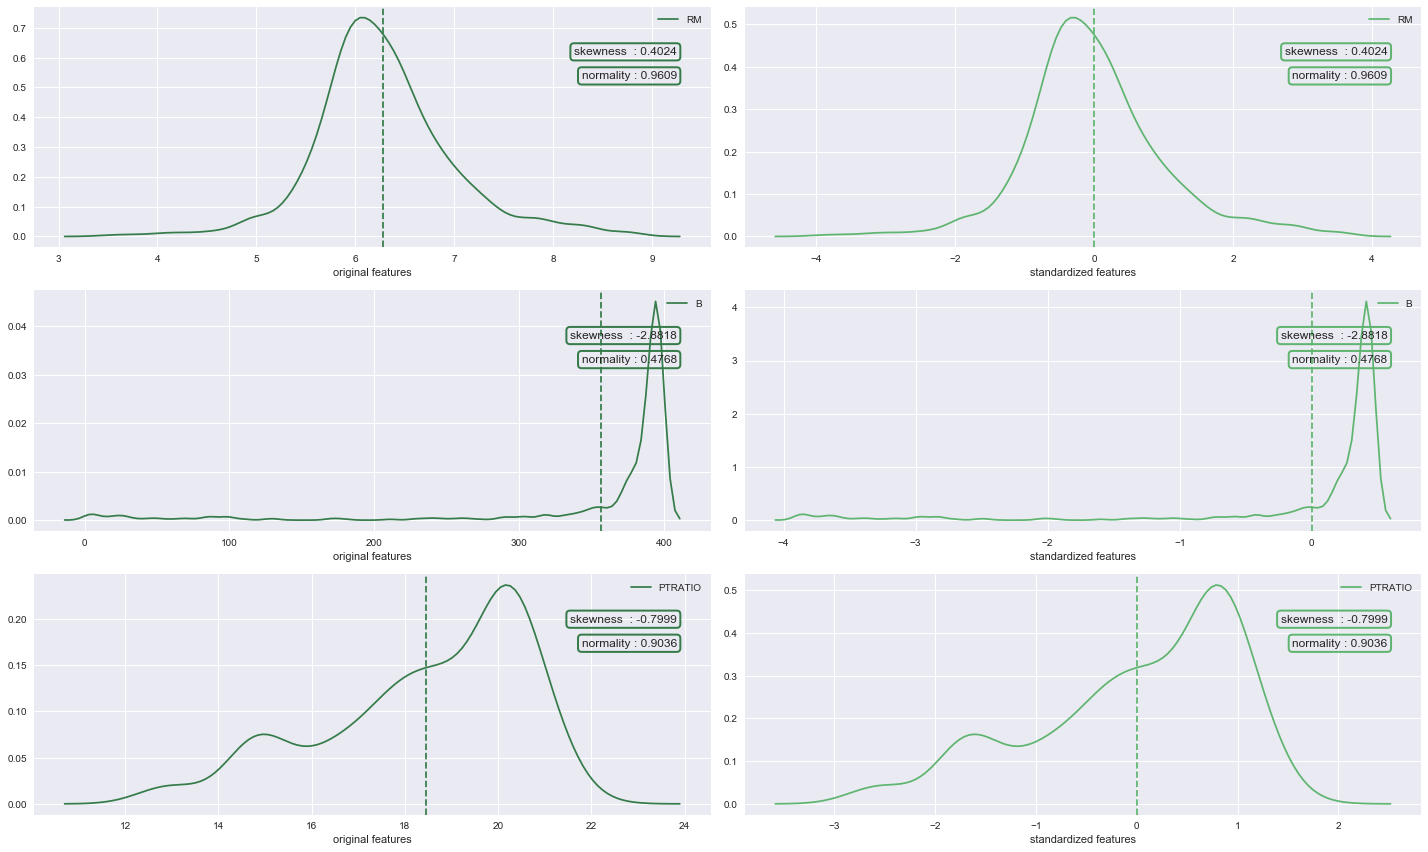

In [9]:
plot_list = [
    { 'df' : df,     'xlabel' : 'original features',     'legend_loc' : 'best'},
    { 'df' : df_std, 'xlabel' : 'standardized features', 'legend_loc' : 'best'}
]

visualized_features = selected_features

n_cols = len(plot_list)
fig, axs = plt.subplots(nrows = len(visualized_features), ncols = n_cols, figsize=(20, 4 * len(visualized_features)))    
pal = sns.color_palette("Greens_d", n_cols)

p = 0
for (pl_index, pl_dict) in enumerate(plot_list):      
    for (f_index,f) in enumerate(visualized_features) :
        ax = axs[f_index][pl_index] 
        subset = pl_dict['df'][f]       
        
        skewness = round(stats.skew(subset),4)
        normality = round(stats.shapiro(subset)[0],4)
        
        sns.distplot(a = subset, hist = False, kde = True, rug = False, color = pal[p], ax = ax, label = f)   
        ax.axvline(x = subset.mean(), color = pal[p], linestyle='--')
        
        ax.text(x = 0.95, y = 0.8, horizontalalignment='right', s = ('skewness  : {0}'.format(skewness)),  
            transform = ax.transAxes, bbox = dict(boxstyle = "round, pad=0.3", fill = False, ec = pal[p], lw = 2))
        ax.text(x = 0.95, y = 0.7, horizontalalignment='right', s = ('normality : {0}'.format(normality)),  
            transform = ax.transAxes, bbox = dict(boxstyle = "round, pad=0.3", fill = False, ec = pal[p], lw = 2))        
        
        ax.set_xlabel(pl_dict['xlabel'])
        ax.legend(loc = pl_dict['legend_loc'])
    p += 1
        

plt.tight_layout()
plt.show()


## Impact on the VIF

<br>

In [10]:
vif_list = [
    {'df' : df,     'features' : features, 'label' : 'original'},
    {'df' : df_std, 'features' : features, 'label' : 'standardized'},
]

template = "{0:<20}:{1:>10}" 
   
for vl in vif_list:    
    vif_dict = uc.compute_vif(df = vl['df'], features = vl['features'])
    print('VIF ({0})'.format(vl['label']))
    print()
    for (key, value) in vif_dict.items():
        print(template.format(key, round(value,4)))
    print()
    print()


VIF (original)

CRIM                :    2.0746
ZN                  :    2.8439
INDUS               :   14.4843
CHAS                :    1.1529
NOX                 :   73.9022
RM                  :    77.935
AGE                 :   21.3868
DIS                 :   14.6994
RAD                 :   15.1547
TAX                 :   61.2269
PTRATIO             :   85.0273
B                   :    20.066
LSTAT               :   11.0889


VIF (standardized)

CRIM                :    2.0799
ZN                  :    2.8219
INDUS               :   14.3687
CHAS                :    1.1533
NOX                 :   51.0486
RM                  :    1.8418
AGE                 :   21.0204
DIS                 :    8.1886
RAD                 :   15.2063
TAX                 :   58.8879
PTRATIO             :    1.7769
B                   :    1.3179
LSTAT               :   12.1651




## Impact on the intercept

<br>

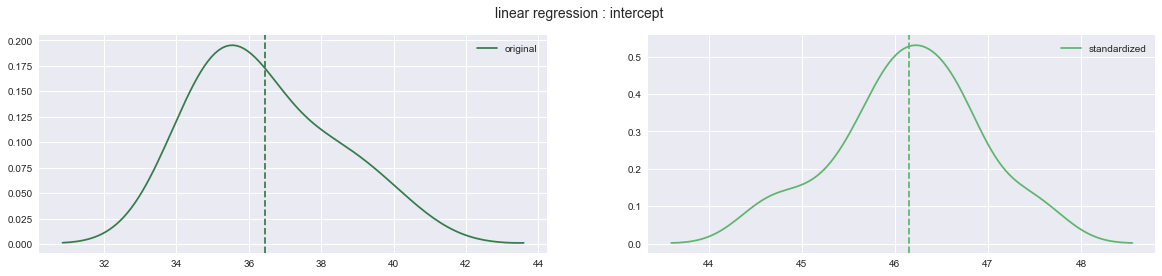

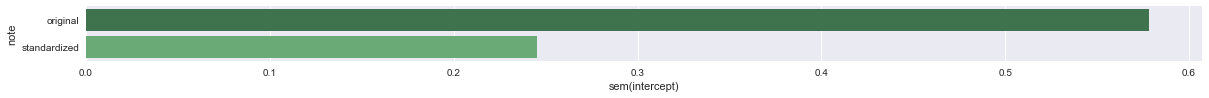

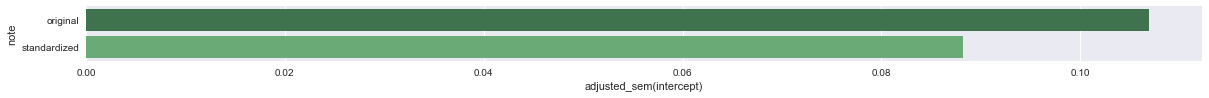

In [11]:
up.plot_across_discriminant(
    df = results, 
    cols = ['intercept'], 
    discriminant_col = 'note', 
    plot_args = {'title' : 'linear regression', 'skewness' : False, 'normality' : False}, 
    distplot = True,
    sem      = True, 
    adj_sem  = True,
    mean     = False
)

## Impact on the regression coefficients of the transformed features

<br>

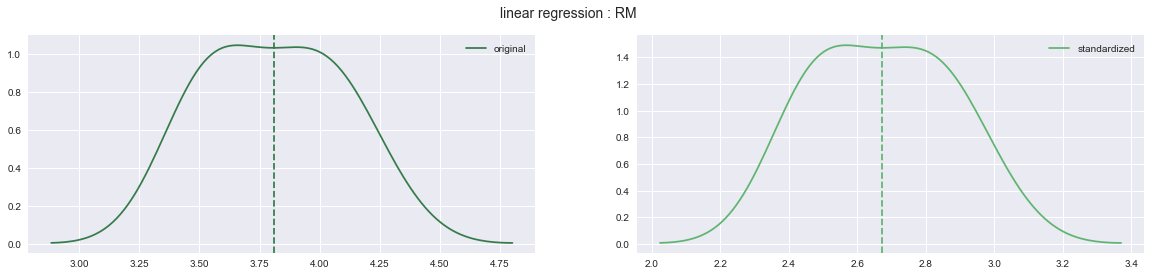

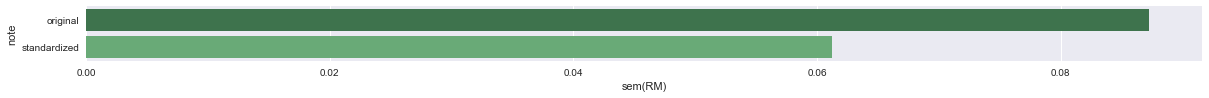

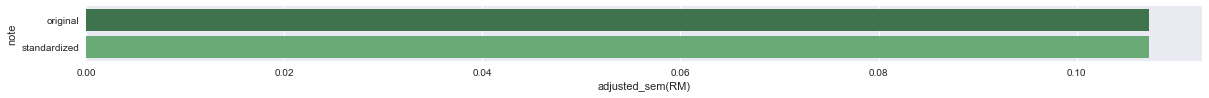

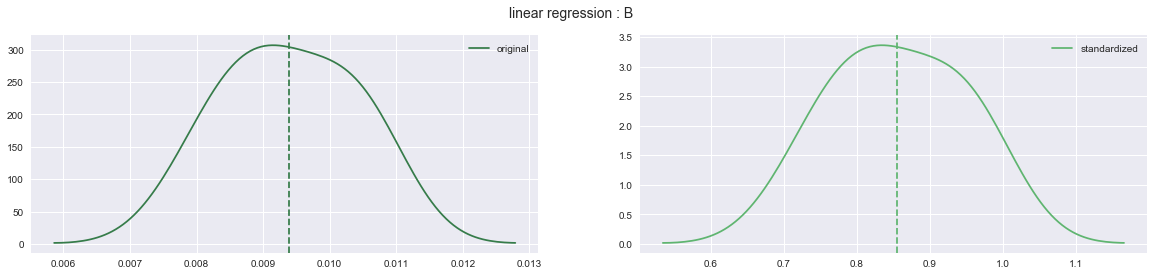

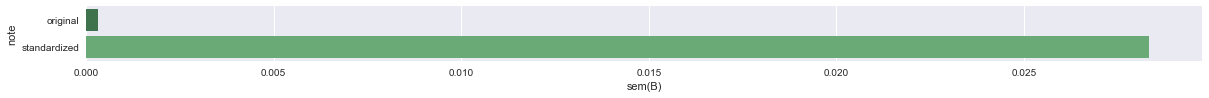

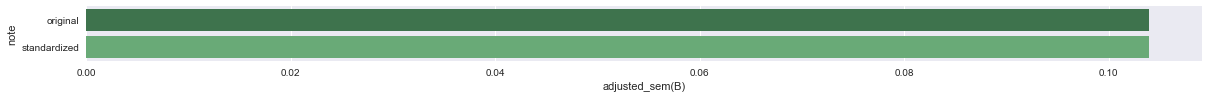

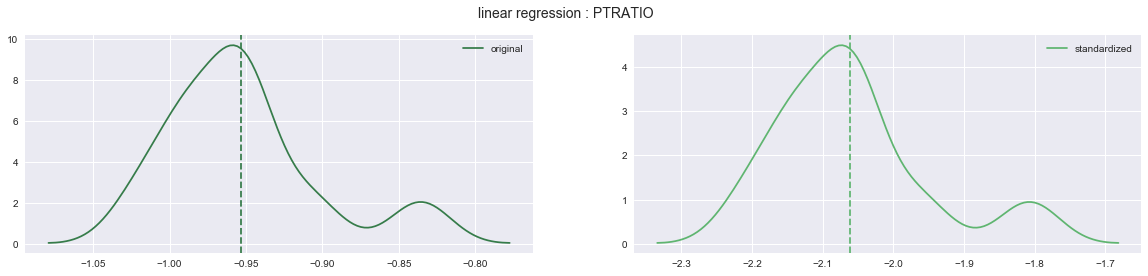

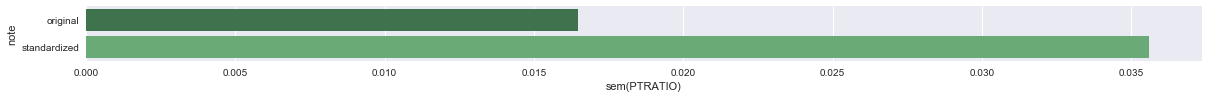

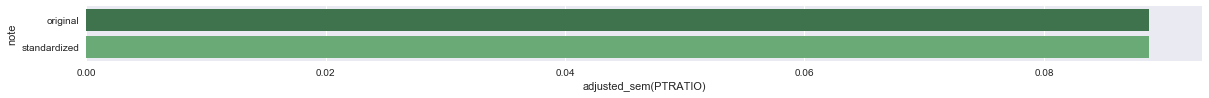

In [12]:
visualized_features = selected_features

up.plot_across_discriminant(
    df = results, 
    cols = visualized_features, 
    discriminant_col = 'note', 
    plot_args = {'title' : 'linear regression', 'skewness' : False, 'normality' : False}, 
    distplot = True,
    sem      = True, 
    adj_sem  = True,
    mean     = False
)    
    

## Impact on the regression coefficients of the non-transformed features

<br>
In the graphs below only three of the ten non-scaled feature are represented, but the plots all show the same result. 

<br>
The distributions of the regression coefficients have changed for the non-scaled features as well, but it's hard to tell if we are looking at a linear combination or something else, at least for the moment.

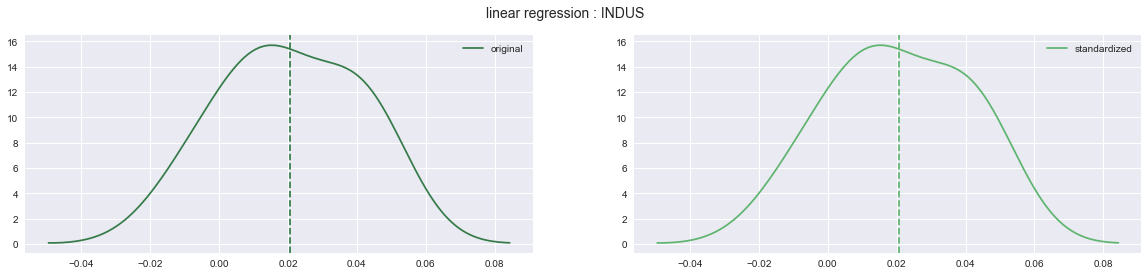

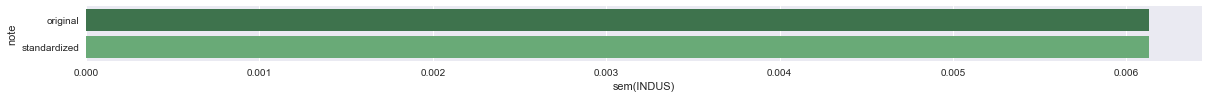

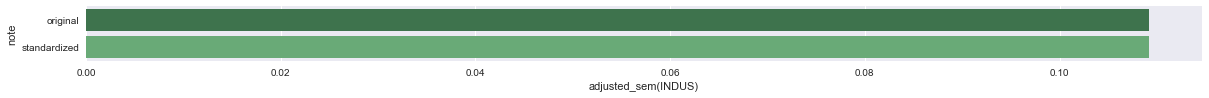

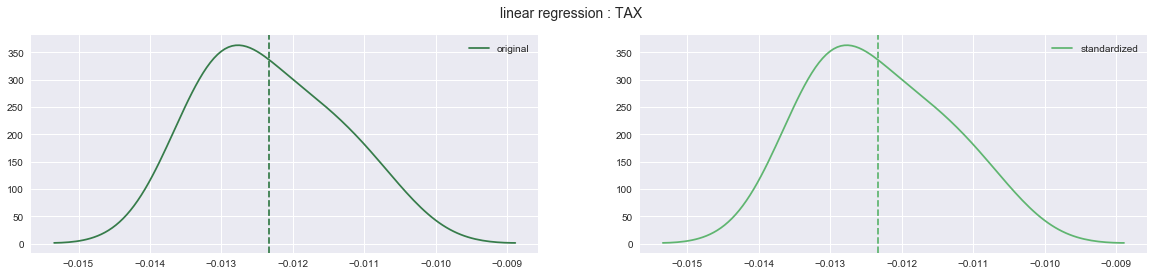

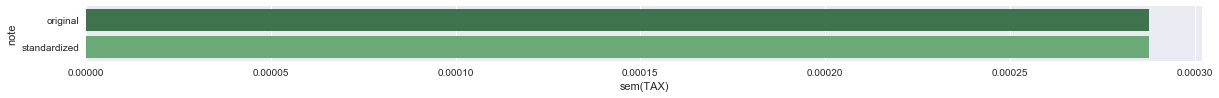

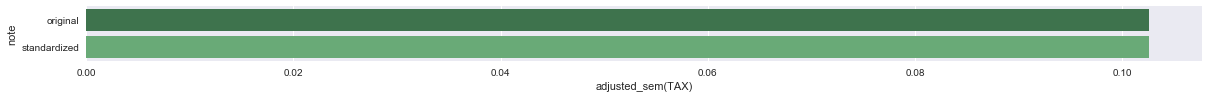

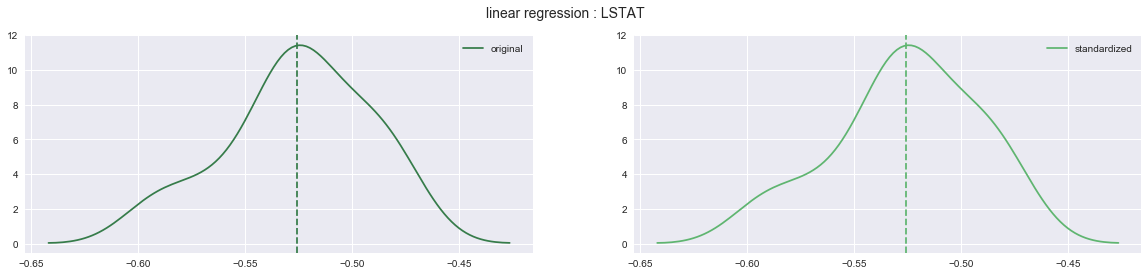

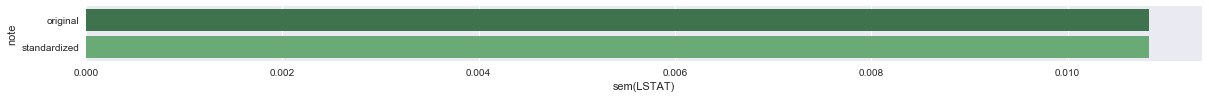

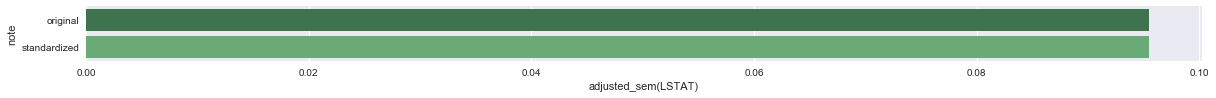

In [13]:
#non_selected_features = [f for f in features if (f not in selected_features)]
non_selected_features = ['INDUS', 'TAX', 'LSTAT']
visualized_features = non_selected_features

up.plot_across_discriminant(
    df = results, 
    cols = visualized_features, 
    discriminant_col = 'note', 
    plot_args = {'title' : 'linear regression', 'skewness' : False, 'normality' : False}, 
    distplot = True,
    sem      = True, 
    adj_sem  = True,
    mean     = False
)


## Impact on the regression score

<br>
The distribution of the regression scores has changed as well but it's hard to determine the underlying relationship (if that exists) just by looking at the plot below.

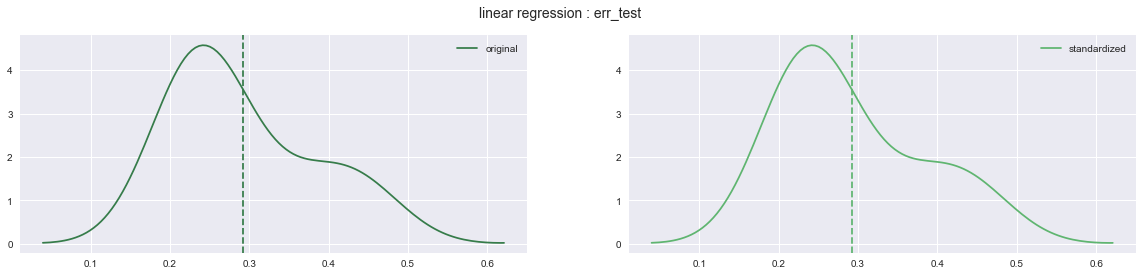

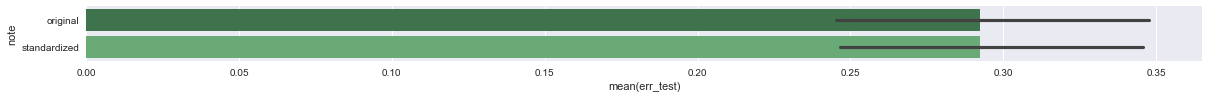

In [15]:
up.plot_across_discriminant(
    df = results, 
    cols = ['err_test'], 
    discriminant_col = 'note', 
    plot_args = {'title' : 'linear regression', 'skewness' : False, 'normality' : False}, 
    distplot = True,
    sem      = False, 
    adj_sem  = False,
    mean     = True
)


## References

<br>
<ul style="list-style-type:square">
    <li>
        Sebastian Raschka - About Feature Scaling and Normalization <br>
        http://sebastianraschka.com/Articles/2014_about_feature_scaling.html
    </li>
</ul>